# 📊 Phase 1: Exploratory Data Analysis (EDA) - Diabetes Adherence

This notebook performs exploratory analysis on the diabetes adherence dataset.  
We explore dataset structure, inspect adherence behavior, and prepare a binary target variable for modeling.


### 🔹 Step 1: Load the Dataset

We load the raw diabetes dataset using pandas and view its dimensions and sample rows.


In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('../dataset/raw/Diabetes Adherence Data.csv')

# Shape and sample
print("Shape:", df.shape)
df.head()


### 🔹 Step 2: Inspect Column Types and Missing Values

We check the data types and identify missing values across columns.
This helps us determine which columns need cleanup or conversion.


In [3]:
# Overview of columns and types
df.info()

# Missing values per column
df.isnull().sum().sort_values(ascending=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52616 entries, 0 to 52615
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MEMBER                52616 non-null  int64  
 1   INO                   52616 non-null  int64  
 2   PZTIQNT NZXQ          52616 non-null  object 
 3   ADHERENCE             52616 non-null  int64  
 4   GENDER                52616 non-null  object 
 5   PRACTICE NO           52616 non-null  int64  
 6   DIS                   52616 non-null  int64  
 7   PROVIDER              52616 non-null  object 
 8   AS AT NETWORKS        41358 non-null  object 
 9   REFERRING PRACTICE    51754 non-null  float64
 10  PAYER NAME            52616 non-null  object 
 11  INV REF               52616 non-null  object 
 12  SERVICE DATE          52616 non-null  object 
 13  ASSESS DATE           52616 non-null  object 
 14  DATE RECEIVED         52616 non-null  object 
 15  CLM CODE           

SCRIPT CODE             52616
DUPLICATE CLAIM LINE    52616
DUPLICATE CLAIM         52616
AUTH NO                 13388
AS AT NETWORKS          11258
REFERRING PRACTICE        862
MEMBER                      0
TOTAL AMOUNT PAID           0
TARIFF                      0
CO-PAY                      0
PAY TO                      0
REJ                         0
REV                         0
CLAIM NO                    0
DL                          0
PAID FROM SAVINGS           0
CLAIM LINE NO               0
OPTION NAME                 0
PAPER/EDI                   0
ASSESSOR NAME               0
BIRTHDATE                   0
RECOVERY AMOUNT             0
PAID FROM RISK AMT          0
PAID FROM THRESHHOLD        0
INO                         0
PZTIQNT NZXQ                0
ADHERENCE                   0
GENDER                      0
PRACTICE NO                 0
DIS                         0
PROVIDER                    0
PAYER NAME                  0
INV REF                     0
SERVICE DA

### 🔹 Step 3: Check Adherence Value Distribution

The `ADHERENCE` column represents adherence levels (1–13).  
We check its distribution to understand how adherence levels are spread across the dataset.


In [6]:
# Check class distribution
df['ADHERENCE'].value_counts(dropna=False)



ADHERENCE
12    10980
11    10250
10     8595
9      6513
8      4592
7      3223
6      2423
5      1911
4      1391
3      1038
2       846
1       829
13       25
Name: count, dtype: int64

### 🔹 Step 4: Create Binary Target Variable

We define a binary label `ADHERENT_BINARY`:
- `1` = Adherence score ≥ 8  
- `0` = Adherence score < 8  

This binary target will be used for classification modeling.


In [5]:
# Create binary target from adherence levels
df['ADHERENT_BINARY'] = df['ADHERENCE'].apply(lambda x: 1 if x >= 8 else 0)

# Check binary label distribution
df['ADHERENT_BINARY'].value_counts(normalize=True).round(3)


ADHERENT_BINARY
1    0.778
0    0.222
Name: proportion, dtype: float64

### 🔹 Step 5: Convert Date Columns to Datetime Format

We convert key date columns to `datetime` objects:
- `SERVICE DATE`
- `ASSESS DATE`
- `DATE RECEIVED`
- `BIRTHDATE`

This allows us to calculate time intervals and verify patient age.


In [7]:
# Convert important date columns to datetime
date_cols = ['SERVICE DATE', 'ASSESS DATE', 'DATE RECEIVED', 'BIRTHDATE']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce', dayfirst=False)

# Preview conversion
df[date_cols].dtypes


SERVICE DATE     datetime64[ns]
ASSESS DATE      datetime64[ns]
DATE RECEIVED    datetime64[ns]
BIRTHDATE        datetime64[ns]
dtype: object

### 🔹 Step 6: Calculate Age and Time Gaps

We verify whether `CURRENT AGE` aligns with the year of birth from `BIRTHDATE`.  
We also calculate:
- Days between `SERVICE DATE` and `ASSESS DATE`
- Days between `SERVICE DATE` and `DATE RECEIVED`

These temporal features may help in modeling patient behavior patterns.


In [8]:
# Recalculate age from BIRTHDATE
df['CALCULATED_AGE'] = pd.to_datetime('today').year - df['BIRTHDATE'].dt.year

# Compare calculated vs provided age
df[['CURRENT AGE', 'CALCULATED_AGE']].describe()

# Time between service and assess
df['DAYS_BETWEEN_SERVICE_AND_ASSESS'] = (df['ASSESS DATE'] - df['SERVICE DATE']).dt.days

# Time between service and received
df['DAYS_BETWEEN_SERVICE_AND_RECEIVED'] = (df['DATE RECEIVED'] - df['SERVICE DATE']).dt.days

# Quick sanity check
df[['DAYS_BETWEEN_SERVICE_AND_ASSESS', 'DAYS_BETWEEN_SERVICE_AND_RECEIVED']].describe()


,DAYS_BETWEEN_SERVICE_AND_ASSESS,DAYS_BETWEEN_SERVICE_AND_RECEIVED
count,20765.000000,20787.000000
mean,2.141729,1.853899
std,24.958910,20.200236
min,-331.000000,-303.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,570.000000,476.000000


### 🧠 Insight: Time Between Service, Assessment, and Receipt

- Most patients had **same-day service and assessment**, with the median gap being `0 days`.
- However, some entries show **negative gaps**, such as assessments or receipts occurring **before** the recorded service date. These may reflect:
  - Data entry errors
  - Misaligned timestamps
  - Late or pre-dated logging

#### 📊 Summary Stats:
- `DAYS_BETWEEN_SERVICE_AND_ASSESS`: Mean = 2.14 days, Min = -331, Max = 570
- `DAYS_BETWEEN_SERVICE_AND_RECEIVED`: Mean = 1.85 days, Min = -303, Max = 476

While these values show variation, we will keep them for now and possibly:
- Flag outliers in later analysis
- Engineer binary or categorical features (e.g., "delayed service", "early assess")


### 🔹 Step 7: Analyze Refill Patterns Per Patient

We now examine refill behavior for each patient (`MEMBER`).  
By grouping claims by `MEMBER` and sorting by `SERVICE DATE`, we can later calculate:
- Refill frequency
- Gaps between visits
- Adherence patterns over time


In [9]:
# Sort by patient and service date
df_sorted = df.sort_values(by=['MEMBER', 'SERVICE DATE'])

# Check number of visits per patient
visit_counts = df_sorted['MEMBER'].value_counts()
print("Median number of visits per patient:", visit_counts.median())
visit_counts.describe()


Median number of visits per patient: 11.0


count    4444.000000
mean       11.839784
std         8.800716
min         1.000000
25%         5.000000
50%        11.000000
75%        17.000000
max        68.000000
Name: count, dtype: float64

➡️ On average, each patient has ~12 refill visits, with a median of 11 and some having up to 68, indicating strong longitudinal refill behavior suitable for time-gap analysis and modeling.


### 🔹 Step 8: Calculate Days Since Last Refill Per Patient

To capture refill behavior, we compute the number of days between each patient's consecutive `SERVICE DATE` entries.
This helps identify refill frequency, irregularity, or gaps in medication adherence.


In [10]:
# Ensure sorting by patient and date
df_sorted = df.sort_values(by=['MEMBER', 'SERVICE DATE'])

# Calculate refill gap per patient
df_sorted['DAYS_SINCE_LAST_REFILL'] = df_sorted.groupby('MEMBER')['SERVICE DATE'].diff().dt.days

# Preview
df_sorted[['MEMBER', 'SERVICE DATE', 'DAYS_SINCE_LAST_REFILL']].head(10)


,MEMBER,SERVICE DATE,DAYS_SINCE_LAST_REFILL
47110,92222888,2022-06-02,NaN
47109,92222888,2022-09-01,91.0
20218,92222888,2022-09-07,6.0
47111,92222888,NaT,NaN
47112,92222888,NaT,NaN
20212,92222969,2022-01-08,NaN
20213,92222969,2022-01-08,0.0
47105,92222969,2022-03-05,56.0
47106,92222969,2022-03-05,0.0
47103,92222969,2022-04-04,30.0


➡️ The `DAYS_SINCE_LAST_REFILL` feature shows refill behavior across visits.  
Most patients have regular gaps (e.g., 30, 60, 90 days), while same-day entries appear as `0`.  
Missing `SERVICE DATE` entries result in `NaT` and will be handled during cleanup.


### 🔹 Step 9: Analyze Refill Gap Distribution

We explore the distribution of `DAYS_SINCE_LAST_REFILL` to identify typical refill cycles, spot outliers, and understand adherence behaviors over time.


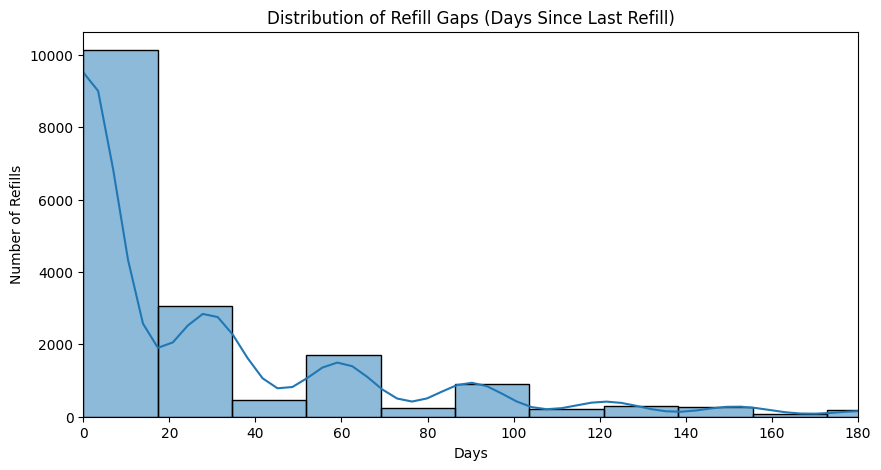

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Drop NaN refill gaps for histogram
gap_data = df_sorted['DAYS_SINCE_LAST_REFILL'].dropna()

# Plot histogram
plt.figure(figsize=(10, 5))
sns.histplot(gap_data, bins=40, kde=True)
plt.title("Distribution of Refill Gaps (Days Since Last Refill)")
plt.xlabel("Days")
plt.ylabel("Number of Refills")
plt.xlim(0, 180)
plt.show()


### 🧠 Insight: Refill Gap Distribution

- The majority of patients refill their prescriptions within **0–15 days**, suggesting frequent or same-day service interactions.
- Noticeable spikes appear at **30, 60, 90, and 120 days**, indicating structured refill cycles (e.g., monthly, bi-monthly).
- Few outliers exist beyond 150 days, which may indicate poor adherence or data irregularities.

This distribution will help us engineer features like average refill gap, longest delay, and refill regularity per patient.


## ✅ Phase 1 Summary: Exploratory Data Analysis (EDA)

This phase focused on understanding the structure, behavior, and readiness of the diabetes adherence dataset. Key steps and insights include:

### 🧾 Dataset Overview
- 52,616 claim-level records
- 4,444 unique patients
- Median of 11 refill visits per patient (up to 68)
- Real-world data including service dates, amounts, genders, diagnosis codes, and pharmacy visits

### 🎯 Target Variable
- Created binary target `ADHERENT_BINARY` using adherence level ≥ 8
- Class balance: 78% adherent, 22% non-adherent — realistic imbalance

### ⏳ Temporal Features
- Converted all key date columns to datetime (`SERVICE DATE`, `ASSESS DATE`, `BIRTHDATE`, etc.)
- Engineered time deltas:
  - `DAYS_BETWEEN_SERVICE_AND_ASSESS`
  - `DAYS_BETWEEN_SERVICE_AND_RECEIVED`
  - `DAYS_SINCE_LAST_REFILL` (per patient)

### 📊 Refill Behavior Insights
- Strong refill cycle patterns observed at 30, 60, 90 days
- Most visits occur close together (0–15 day gaps), with some large delays or inconsistencies
- Dataset is rich in temporal behavior, suitable for time-aware modeling

---

The dataset is now clean, labeled, and enriched with time-based features.  
Ready to move into **Phase 2: Feature Engineering & Aggregation per Patient**.
